In [2]:
#import spikeinterface modules
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import numpy as np

#import everything else
import os
import sys
import numpy as np
import neo
import pandas as pd
import h5py
import McsPy
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

    Toy example using the extractors module:
    

In [141]:
recording, sorting_true = se.example_datasets.toy_example(duration=10, num_channels=4, seed=0)


The .h5 files to actually try spike sorting. 

In [3]:
filedirec = "/Users/jonas/Documents/DATA/TIRAL_H5_fileformat/"
filename = "HCxA_Chr2_light_5V_100light_2000stop_position8.h5"
scriptdirec="/Users/jonas/Documents/CODE/Untitled Folder/"

First problem is: We need a probe file, that takes the random configuration of channels of the MCS - MEA System into account. Let us first review the 'order' MCS channeles: 

In [4]:
channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirec, filename))


In [20]:
# find out, where our channel labels are hiding
channel_raw_data.recordings[0].analog_streams[0].channel_infos[1]
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]


In [21]:
ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,


Here is the channel_id

In [22]:
# here we find in the info part of channel infos all we search: info is a dictionary which
# has the 'Label' key
channel_raw_data.recordings[0].analog_streams[0].channel_infos[0].info


{'ChannelID': 0,
 'RowIndex': 0,
 'GroupID': 0,
 'ElectrodeGroup': 0,
 'Label': 'R12',
 'RawDataType': 'Int',
 'Unit': 'V',
 'Exponent': -12,
 'ADZero': 0,
 'Tick': 40,
 'ConversionFactor': 104166,
 'ADCBits': 16,
 'HighPassFilterType': '',
 'HighPassFilterCutOffFrequency': '-1',
 'HighPassFilterOrder': -1,
 'LowPassFilterType': '',
 'LowPassFilterCutOffFrequency': '-1',
 'LowPassFilterOrder': -1}

In [ ]:
Next, we create a dictionary. As keys we use the 

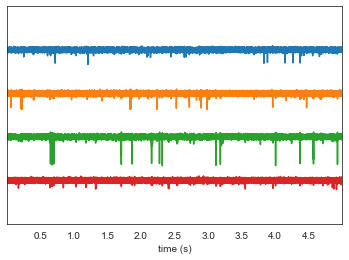

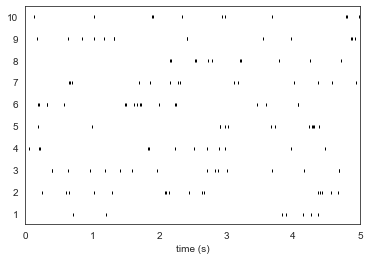

In [143]:
w_ts = sw.plot_timeseries(recording, trange=[0,5])
w_rs = sw.plot_rasters(sorting_true, trange=[0,5])
#w_wf = sw.plot_unit_waveforms(recording, sorting, max_spikes_per_unit=100)


Extracting infor from recording:

In [60]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()


In [55]:
num_chan

4

In [38]:
import spikeextractors as se




# MEA DATA

In [144]:
recording=se.MCSH5RecordingExtractor(filedirec+filename)

In [145]:
channel_ids = recording_MEA.get_channel_ids()
fs = recording_MEA.get_sampling_frequency()
num_chan = recording_MEA.get_num_channels()

In [146]:
fs

24999.999999999996

In [147]:
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


In [148]:
spike_train = sorting_true.get_unit_spike_train(unit_id=unit_ids[0])


In [149]:
spike_train

array([ 21478,  36186, 115033, 116600, 124535, 127993, 131277, 159400,
       163465, 164645, 183164, 192248, 196081, 214557, 215749, 233858,
       234350, 250897, 263249, 267532, 284621, 293768])

In [150]:
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)


In [151]:
recording_f

In [152]:
recording_cmr = st.preprocessing.common_reference(recording_f, reference='median')


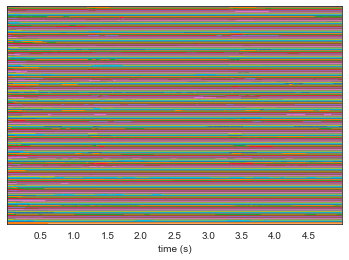

In [153]:
w_ts = sw.plot_timeseries(recording, trange=[0,5])
#w_rs = sw.plot_rasters(sorting_true, trange=[0,5])

In [154]:
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. timepoints = {}'.format(recording.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(recording.get_traces(channel_ids=2))))
print('Location of third electrode = {}'.format(recording.get_channel_property(channel_id=2, property_name='location')))

Num. channels = 252
Sampling frequency = 24999.999999999996 Hz
Num. timepoints = 3000000
Stdev. on third channel = 4.433668937372476e-06
Location of third electrode = [nan nan]


In [113]:
np.shape(recording.get_traces())

(252, 3000000)

In [166]:
recording_mea=recording.load_probe_file(probe_file='/Users/jonas/Documents/CODE/Untitled Folder/small_mea_256.prb')

In [179]:
recording_mea.get_channel_locations()

array([[450., 330.],
       [300., 270.],
       [390., 270.],
       [420., 300.],
       [300., 240.],
       [360., 240.],
       [330., 210.],
       [450., 210.],
       [390., 150.],
       [360., 180.],
       [450.,  90.],
       [420., 120.],
       [450.,  30.],
       [330., 120.],
       [270., 150.],
       [240., 210.],
       [300.,  30.],
       [330.,   0.],
       [240.,  90.],
       [270.,  60.],
       [210.,   0.],
       [240., 150.],
       [180.,  90.],
       [210., 120.],
       [120.,  30.],
       [150.,  60.],
       [360., 360.],
       [390., 390.],
       [450., 360.],
       [300., 300.],
       [390., 300.],
       [420., 330.],
       [330., 240.],
       [360., 270.],
       [300., 210.],
       [450., 240.],
       [390., 180.],
       [360., 210.],
       [450., 120.],
       [420., 150.],
       [270., 180.],
       [300., 180.],
       [360.,  90.],
       [390.,  60.],
       [360.,   0.],
       [300., 150.],
       [300.,  60.],
       [330.,

In [181]:
w_el_tetrode = sw.plot_electrode_geometry(recording_mea)


AttributeError: 'location' not found as a property

In [ ]:
probe = 

In [ ]:
sorting_hs = ss.run_herdingspikes(recording, probe)

In [69]:
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())


Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'klusta', 'mountainsort4', 'spykingcircus', 'tridesclous', 'waveclus']
Installed sorters ['herdingspikes', 'mountainsort4', 'spykingcircus', 'tridesclous']


In [89]:
print(ss.get_default_params('spykingcircus'))


{'detect_sign': -1, 'adjacency_radius': 100, 'detect_threshold': 6, 'template_width_ms': 3, 'filter': True, 'merge_spikes': True, 'auto_merge': 0.75, 'num_workers': None, 'whitening_max_elts': 1000, 'clustering_max_elts': 10000}


In [86]:
print(ss.get_default_params('herdingspikes'))

{'clustering_bandwidth': 5.5, 'clustering_alpha': 5.5, 'clustering_n_jobs': -1, 'clustering_bin_seeding': True, 'clustering_min_bin_freq': 16, 'clustering_subset': None, 'left_cutout_time': 0.3, 'right_cutout_time': 1.8, 'detect_threshold': 20, 'probe_masked_channels': [], 'probe_inner_radius': 70, 'probe_neighbor_radius': 90, 'probe_event_length': 0.26, 'probe_peak_jitter': 0.2, 'num_com_centers': 1, 'maa': 12, 'ahpthr': 11, 'out_file_name': 'HS2_detected', 'decay_filtering': False, 'save_all': False, 'amp_evaluation_time': 0.4, 'spk_evaluation_time': 1.0, 'pca_ncomponents': 2, 'pca_whiten': True, 'freq_min': 300.0, 'freq_max': 6000.0, 'filter': True, 'pre_scale': True, 'pre_scale_value': 20.0, 'filter_duplicates': True}


In [87]:
print(ss.get_default_params('tridesclous'))


{'freq_min': 400.0, 'freq_max': 5000.0, 'detect_sign': -1, 'detect_threshold': 5, 'peak_span_ms': 0.7, 'wf_left_ms': -2.0, 'wf_right_ms': 3.0, 'feature_method': 'auto', 'cluster_method': 'auto', 'clean_catalogue_gui': False, 'chunk_mb': 500, 'n_jobs_bin': 1}


In [90]:
sorting_spykingcircus= ss.run_spykingcircus(recording_cmr, filter=False, )

Warning! The recording is already filtered, but Spyking-Circus filter is enabled. You can disable filters by setting 'filter' parameter to False
RUNNING SHELL SCRIPT: /Users/jonas/Documents/CODE/Untitled Folder/spykingcircus_output/run_spykingcircus.sh


SpikeSortingError: Spike sorting failed: spykingcircus returned a non-zero exit code. You can inspect the runtime trace in the spykingcircus.log of the output folder.'

In [77]:
sorting_tridesclous

In [78]:
print('Units found by Tridesclous:', sorting_tridesclous.get_unit_ids())


Units found by Tridesclous: [0, 1, 2, 3]


In [79]:
st.postprocessing.export_to_phy(recording, sorting_tridesclous, output_folder='phy')


Recomputing info


In [80]:
phy template-gui phy/params.py

SyntaxError: invalid syntax (<ipython-input-80-56cca5fb1a42>, line 1)